In [1]:
import glob
#import math
import cmocean
import h5py as h5
import numpy as np
import pandas as pd
import splotch as sp
import cmocean as cmo
import matplotlib.cm as cm
#import scipy.stats as stats
import scipy.optimize as opti
#import matplotlib.colors as col
import matplotlib.lines as lines
import matplotlib.pyplot as plot
import matplotlib.gridspec as gs
import scipy.interpolate as interp
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerTuple
%matplotlib inline

In [2]:
sp.use_style('/home/mbravo/Documents/pypati.style')
new_fig_size=np.array(plot.rcParams.get('figure.figsize'))

# Defining functions

## Metric measurement

In [3]:
def slope_func(dust_comp,ebvmap,dusted=False):
    if dusted:
        dust_comp['deltaEBV']=dust_comp['EBV']
        temp=dust_comp.loc[dust_comp['deltaEBV']<0.1]
    else:
        dust_comp['deltaEBV']=dust_comp['EBV']-np.median(ebvmap)
        temp=dust_comp.loc[(dust_comp['deltaEBV']>-0.05)&(dust_comp['deltaEBV']<0.05)]
    max_debv=temp['deltaEBV']==np.max(temp['deltaEBV'])
    min_debv=temp['deltaEBV']==np.min(temp['deltaEBV'])
    cen_debv=np.abs(temp['deltaEBV'])==np.min(np.abs(temp['deltaEBV']))
    
    md=(float(temp.loc[max_debv,'delta'])-float(temp.loc[min_debv,'delta']))/0.1
    mm=(float(temp.loc[max_debv,'mag'])-float(temp.loc[min_debv,'mag']))/0.1
    mc=(float(temp.loc[max_debv,'col'])-float(temp.loc[min_debv,'col']))/0.1
    
    dust_comp['delta']-=np.mean(temp.loc[cen_debv,'delta'])
    dust_comp['mag']-=np.mean(temp.loc[cen_debv,'mag'])
    dust_comp['col']-=np.mean(temp.loc[cen_debv,'col'])
    
    return(dust_comp,md,mm,mc)

## Map recovery

In [4]:
def map_recovery(ns,dust_table,pixel_data,zrange=[[0.0,0.3],[0.3,0.6],[0.6,0.9],[0.9,1.2],[1.2,2.5]]):
    nside_key=f'n{ns}'
    Debv,ebv_from_delta,ebv_from_mag,ebv_from_col=[],[],[],[]
    EBV_recovery,z_label=[],[]
    EBV_input=pixel_data[f'{nside_key}_EBV']
    for j in range(len(zrange)):
        zr=zrange[j]
        z_label.append(f'$z_{{{np.sum(zr)/2:.2f}}}$')
        z_key=f'z{np.sum(zr)/2:.2f}'.replace('.','')
        
        ####################
        # Delta calc
        ####################
        delta=pixel_data[f'{nside_key}_{z_key}_count']+np.random.uniform(-0.5,0.5,len(pixel_data))
        pixel_data[f'{nside_key}_{z_key}_delta']=np.log10(delta/np.mean(delta))
        
        ####################
        # Read dust vector
        ####################
        dust_vector=dust_table[z_key]
        dust_vector,ebv2d,ebv2m,ebv2c=slope_func(dust_vector,np.array(pixel_data[f'{nside_key}_EBV']))
        
        Debv.append(pixel_data[f'{nside_key}_EBV']-np.median(pixel_data[f'{nside_key}_EBV']))
        ebv_from_delta.append((pixel_data[f'{nside_key}_{z_key}_delta']-np.median(pixel_data[f'{nside_key}_{z_key}_delta']))/ebv2d)
        ebv_from_mag.append((pixel_data[f'{nside_key}_{z_key}_mag']-np.median(pixel_data[f'{nside_key}_{z_key}_mag']))/ebv2m)
        ebv_from_col.append((pixel_data[f'{nside_key}_{z_key}_col']-np.median(pixel_data[f'{nside_key}_{z_key}_col']))/ebv2c)
        
        spl_delta=interp.UnivariateSpline(dust_vector['deltaEBV'],dust_vector['delta'],ext=0)
        spl_mag=interp.UnivariateSpline(dust_vector['deltaEBV'],dust_vector['mag'],ext=0)
        spl_col=interp.UnivariateSpline(dust_vector['deltaEBV'],dust_vector['col'],ext=0)
        
        def dist(val,D,M,C):
            dd=spl_delta(val)
            mm=spl_mag(val)
            cc=spl_col(val)
            return(((D-dd/ebv2d)**2+(M-mm/ebv2m)**2+(C-cc/ebv2c)**2)**0.5)
        
        ebv_recover=np.zeros(len(ebv_from_delta[j]))
        for k in range(len(ebv_from_delta[j])):
            ebv_recover[k]=opti.minimize(dist,x0=0.0,args=(ebv_from_delta[j][k],ebv_from_mag[j][k],ebv_from_col[j][k])).x
        
        EBV_recovery.append(ebv_recover+np.median(EBV_input))
    
    EBV_final=np.array(EBV_recovery)
    EBV_final=np.average(EBV_final,axis=0,weights=1/np.var(EBV_final,axis=1))
    return({'input_map':EBV_input,'input_map_relative':Debv,'output_map_delta':ebv_from_delta,'output_map_mag':ebv_from_mag,
            'output_map_col':ebv_from_col,'output_map_combined':EBV_recovery,'output_map':EBV_final})

# Reading data in

In [5]:
dust_GAL_r248={f'z{f.split("_z")[1][:-4]}':pd.read_csv(f) for f in sorted(glob.glob('../MW_results/MWdust_data/dust_vector_GALFORM_z*.csv'))}
dust_Buz_r248={f'z{f.split("_z")[1][:-4]}':pd.read_csv(f) for f in sorted(glob.glob('../MW_results/MWdust_data/dust_vector_Buzzard_z*.csv'))}
#dust_Buz_r260={f'z{f.split("_z")[1][:-4]}':pd.read_csv(f) for f in sorted(glob.glob('../MW_results/MWdust_data/dust_vector_Buzzard_Deep_z*.csv'))}               

In [6]:
pix_GAL_r248_n6=pd.concat([pd.read_csv(f) for f in sorted(glob.glob('../MW_results/MWdust_data/pixel_n6_GALFORM_*.csv'))],ignore_index=True)
pix_GAL_r248_n9=pd.concat([pd.read_csv(f) for f in sorted(glob.glob('../MW_results/MWdust_data/pixel_n9_GALFORM_*.csv'))],ignore_index=True)
pix_Buz_r248_n6=pd.concat([pd.read_csv(f) for f in sorted(glob.glob('../MW_results/MWdust_data/pixel_n6_Buzzard_*.csv'))],ignore_index=True)
pix_Buz_r248_n9=pd.concat([pd.read_csv(f) for f in sorted(glob.glob('../MW_results/MWdust_data/pixel_n9_Buzzard_*.csv'))],ignore_index=True)
#pix_Buz_r260_n6=pd.concat([pd.read_csv(f) for f in sorted(glob.glob('../MW_results/MWdust_data/pixel_n6_Buzzard_Deep_*.csv'))],ignore_index=True)
#pix_Buz_r260_n9=pd.concat([pd.read_csv(f) for f in sorted(glob.glob('../MW_results/MWdust_data/pixel_n9_Buzzard_Deep_*.csv'))],ignore_index=True)

# Recovering dust maps

## $\mathrm{nside} = 2^6$

In [7]:
map_GAL_r248_n6=map_recovery(6,dust_GAL_r248,pix_GAL_r248_n6)
map_Buz_r248_n6=map_recovery(6,dust_Buz_r248,pix_Buz_r248_n6)
#map_Buz_r260_n6=map_recovery(6,dust_Buz_r260,pix_Buz_r260_n6)

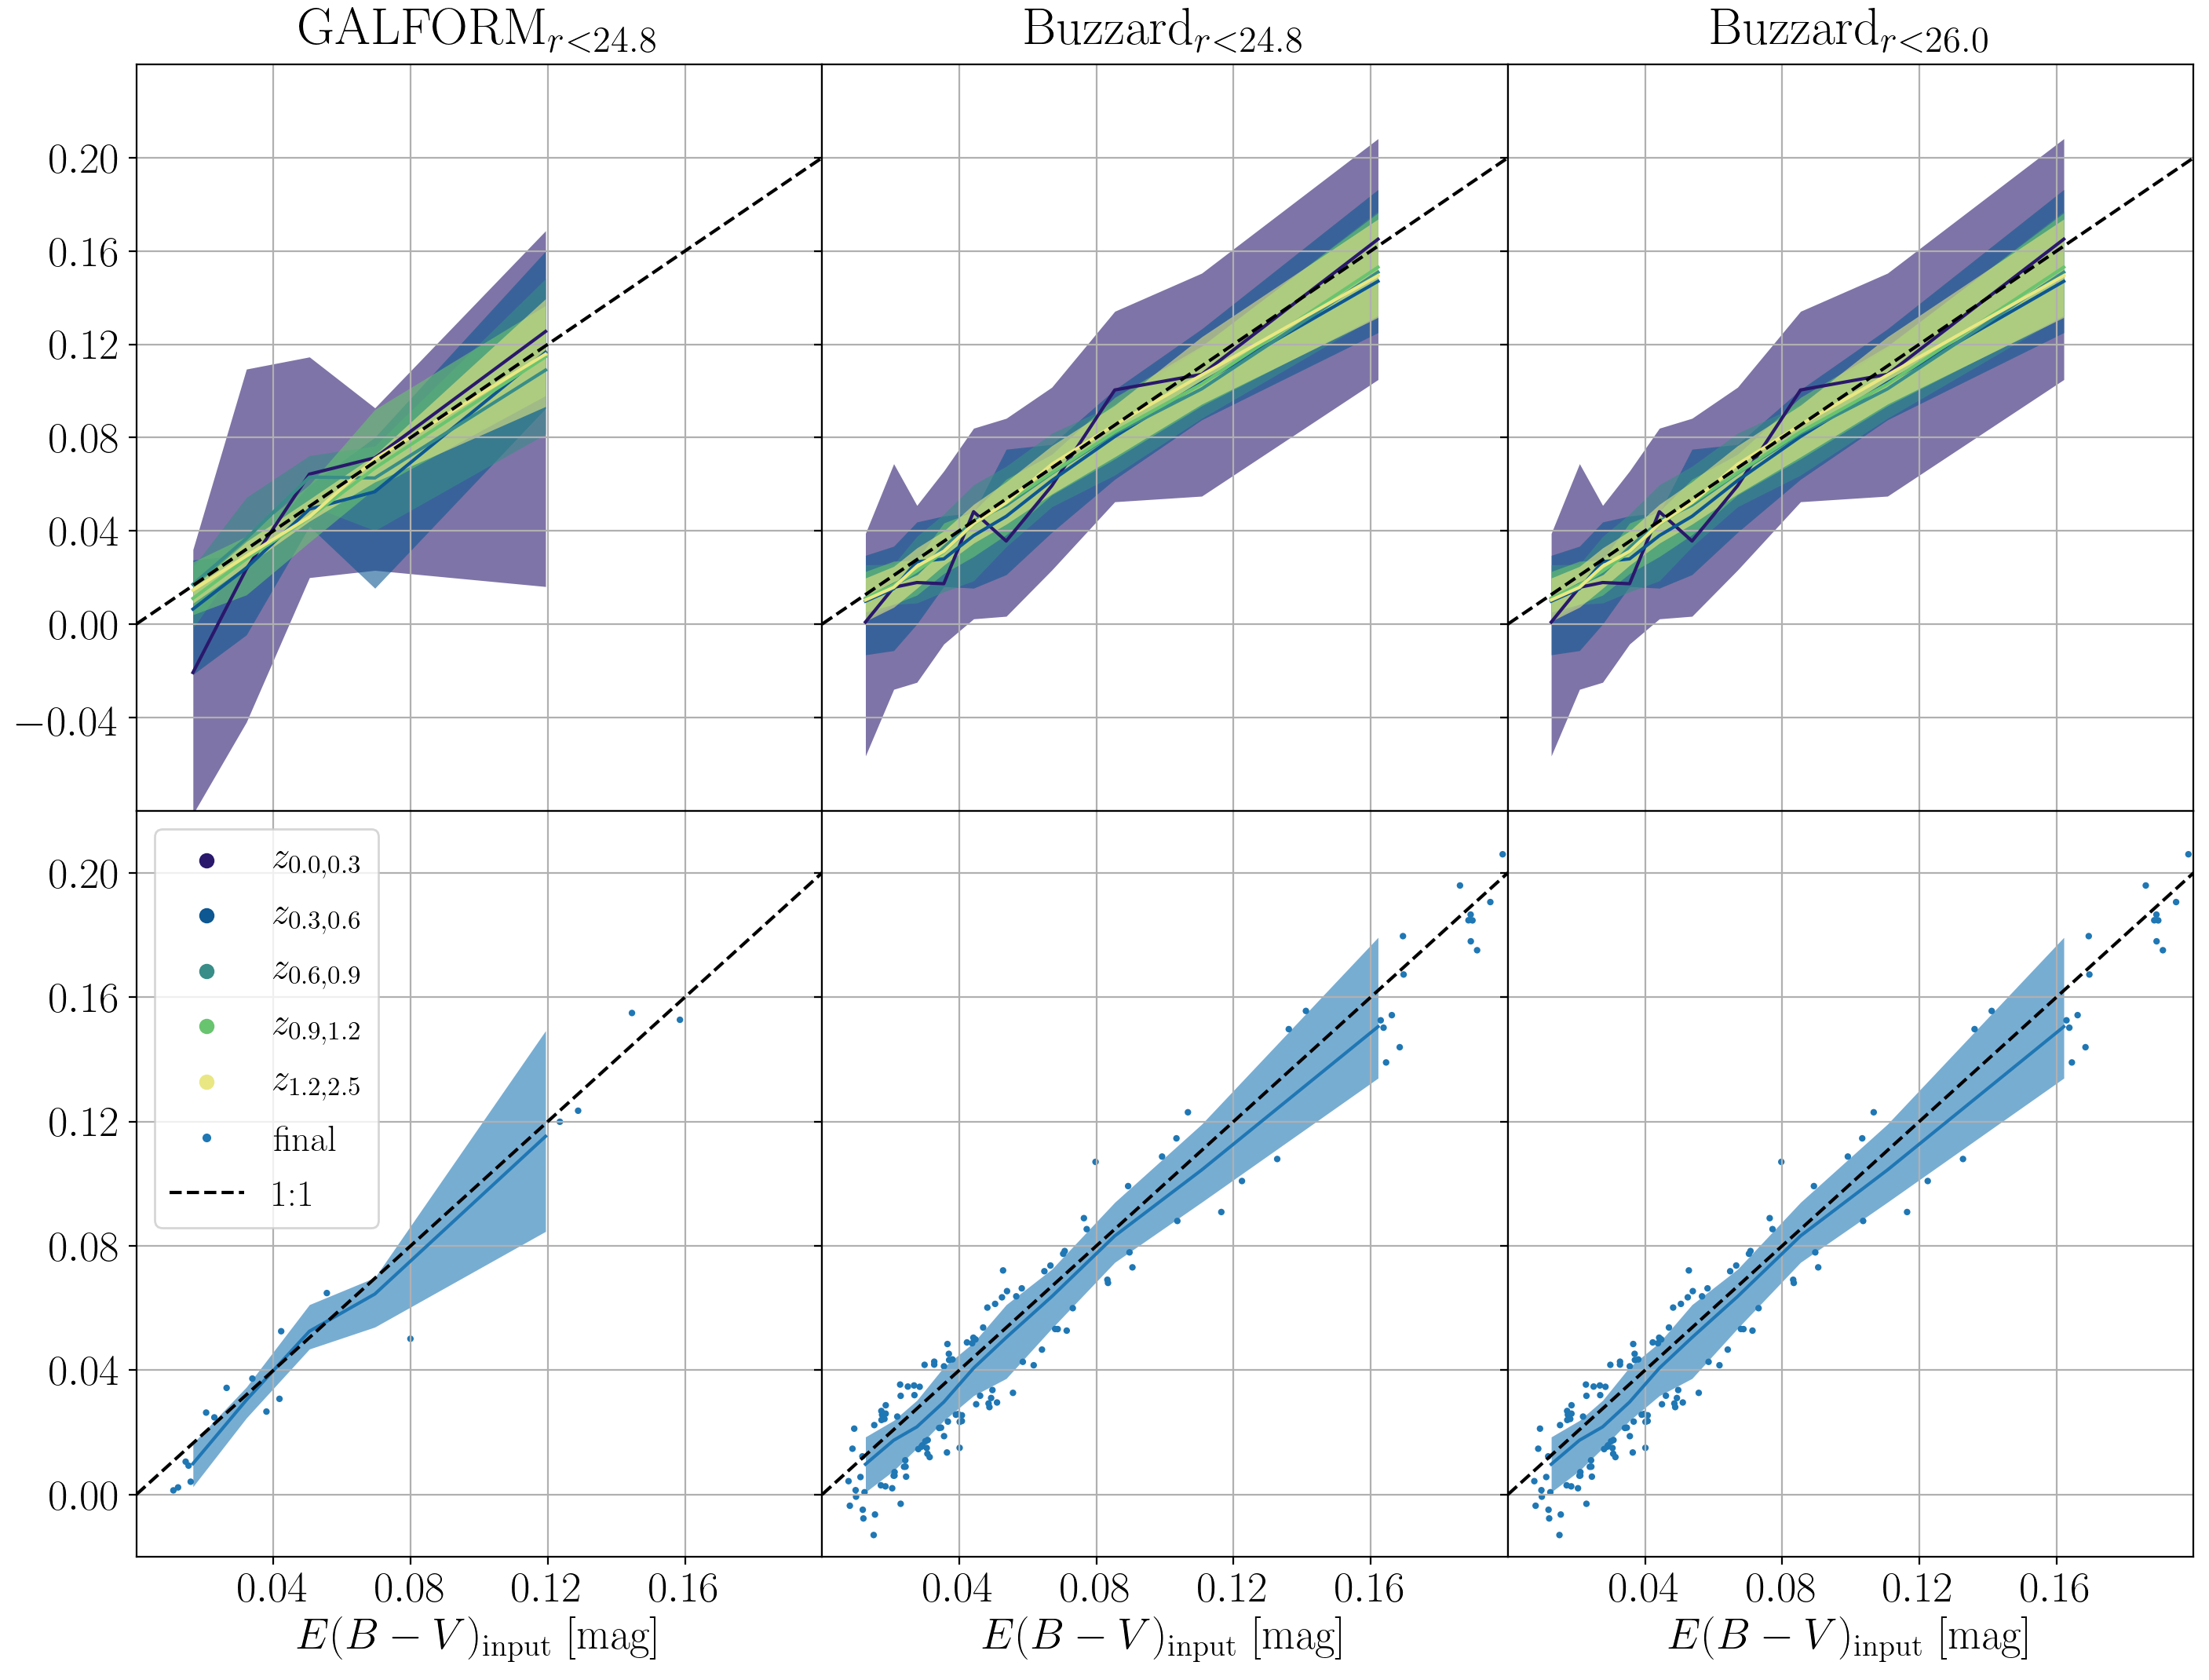

In [59]:
col_map=cm.get_cmap(cmo.cm.haline)

fig=plot.figure(figsize=new_fig_size*2)
spec=gs.GridSpec(nrows=2,ncols=3,figure=fig,wspace=0,hspace=0,left=0.07,right=0.98,bottom=0.07,top=0.95)
fax=[[fig.add_subplot(spec[0,0]),fig.add_subplot(spec[0,1]),fig.add_subplot(spec[0,2])],
     [fig.add_subplot(spec[1,0]),fig.add_subplot(spec[1,1]),fig.add_subplot(spec[1,2])]]
temp=fax[0][1].get_yaxis().set_ticklabels([])
temp=fax[0][2].get_yaxis().set_ticklabels([])
temp=fax[0][0].get_xaxis().set_ticklabels([])
temp=fax[0][1].get_xaxis().set_ticklabels([])
temp=fax[0][2].get_xaxis().set_ticklabels([])
temp=fax[1][1].get_yaxis().set_ticklabels([])
temp=fax[1][2].get_yaxis().set_ticklabels([])
for i in range(2):
    for j in range(3):
        temp=fax[0][j].get_yaxis().set_ticks([-0.04,0,0.04,0.08,0.12,0.16,0.2])
        temp=fax[1][j].get_yaxis().set_ticks([0,0.04,0.08,0.12,0.16,0.2])
        temp=fax[i][j].get_xaxis().set_ticks([0.04,0.08,0.12,0.16])
        fax[i][j].set_rasterized(True)

#GALFORM
fax[0][0].set_title('GALFORM$_{r<24.8}$')
for i in range(L):
    sp.errorband(map_GAL_r248_n6['input_map'],map_GAL_r248_n6['output_map_combined'][i],line_stat='median',bin_type='equal',
                 band_stat_low=16,band_stat_high=84,line=True,ax=fax[0][0],xlim=[0,0.2],ylim=[-0.08,0.24],bins=5,
                 band_kw={'color':col_map(1.0*i/(L-0.8)),'alpha':0.6},line_kw={'c':col_map(1.0*i/(L-0.8))})
sp.axline(a=1,c='k',linestyle='dashed',ax=fax[0][0])
sp.errorband(map_GAL_r248_n6['input_map'],map_GAL_r248_n6['output_map'],line_stat='median',bin_type='equal',bins=5,
                 band_stat_low=16,band_stat_high=84,line=True,ax=fax[1][0],xlim=[0,0.2],ylim=[-0.02,0.22],
                 band_kw={'color':'C0','alpha':0.6},line_kw={'c':'C0'})
outpoint_x,outpoint_y=[],[]
path=fax[1][0].get_children()[0].get_paths()[0]
for i in range(len(map_GAL_r248_n6['input_map'])):
    if not path.contains_point([map_GAL_r248_n6['input_map'][i],map_GAL_r248_n6['output_map'][i]]):
        outpoint_x.append(map_GAL_r248_n6['input_map'][i])
        outpoint_y.append(map_GAL_r248_n6['output_map'][i])
outpoint_x,outpoint_y=[np.array(outpoint_x),np.array(outpoint_y)]
sp.scatter(outpoint_x,outpoint_y,ax=fax[1][0],xlim=[0,0.2],ylim=[-0.02,0.22],xlabel='$E(B-V)_\mathrm{input}$ [mag]',marker='.')
sp.axline(a=1,c='k',linestyle='dashed',ax=fax[1][0])


#Buzzard
fax[0][1].set_title('Buzzard$_{r<24.8}$')
for i in range(L):
    sp.errorband(map_Buz_r248_n6['input_map'],map_Buz_r248_n6['output_map_combined'][i],line_stat='median',bin_type='equal',
                 band_stat_low=16,band_stat_high=84,line=True,ax=fax[0][1],xlim=[0,0.2],ylim=[-0.08,0.24],
                 band_kw={'color':col_map(1.0*i/(L-0.8)),'alpha':0.6},line_kw={'c':col_map(1.0*i/(L-0.8))})
sp.axline(a=1,c='k',linestyle='dashed',ax=fax[0][1])
sp.errorband(map_Buz_r248_n6['input_map'],map_Buz_r248_n6['output_map'],line_stat='median',bin_type='equal',
                 band_stat_low=16,band_stat_high=84,line=True,ax=fax[1][1],xlim=[0,0.2],ylim=[-0.02,0.22],
                 band_kw={'color':'C0','alpha':0.6},line_kw={'c':'C0'})
outpoint_x,outpoint_y=[],[]
path=fax[1][1].get_children()[0].get_paths()[0]
for i in range(len(map_Buz_r248_n6['input_map'])):
    if not path.contains_point([map_Buz_r248_n6['input_map'][i],map_Buz_r248_n6['output_map'][i]]):
        outpoint_x.append(map_Buz_r248_n6['input_map'][i])
        outpoint_y.append(map_Buz_r248_n6['output_map'][i])
outpoint_x,outpoint_y=[np.array(outpoint_x),np.array(outpoint_y)]
sp.scatter(outpoint_x,outpoint_y,ax=fax[1][1],xlim=[0,0.2],ylim=[-0.02,0.22],xlabel='$E(B-V)_\mathrm{input}$ [mag]',marker='.')
sp.axline(a=1,c='k',linestyle='dashed',ax=fax[1][1])

#Buzzard deep
fax[0][2].set_title('Buzzard$_{r<26.0}$')
for i in range(L):
    sp.errorband(map_Buz_r248_n6['input_map'],map_Buz_r248_n6['output_map_combined'][i],line_stat='median',bin_type='equal',
                 band_stat_low=16,band_stat_high=84,line=True,ax=fax[0][2],xlim=[0,0.2],ylim=[-0.08,0.24],
                 band_kw={'color':col_map(1.0*i/(L-0.8)),'alpha':0.6},line_kw={'c':col_map(1.0*i/(L-0.8))})
sp.axline(a=1,c='k',linestyle='dashed',ax=fax[0][2])
sp.errorband(map_Buz_r248_n6['input_map'],map_Buz_r248_n6['output_map'],line_stat='median',bin_type='equal',
                 band_stat_low=16,band_stat_high=84,line=True,ax=fax[1][2],xlim=[0,0.2],ylim=[-0.02,0.22],
                 band_kw={'color':'C0','alpha':0.6},line_kw={'c':'C0'})
outpoint_x,outpoint_y=[],[]
path=fax[1][2].get_children()[0].get_paths()[0]
for i in range(len(map_Buz_r248_n6['input_map'])):
    if not path.contains_point([map_Buz_r248_n6['input_map'][i],map_Buz_r248_n6['output_map'][i]]):
        outpoint_x.append(map_Buz_r248_n6['input_map'][i])
        outpoint_y.append(map_Buz_r248_n6['output_map'][i])
outpoint_x,outpoint_y=[np.array(outpoint_x),np.array(outpoint_y)]
sp.scatter(outpoint_x,outpoint_y,ax=fax[1][2],xlim=[0,0.2],ylim=[-0.02,0.22],xlabel='$E(B-V)_\mathrm{input}$ [mag]',marker='.')
sp.axline(a=1,c='k',linestyle='dashed',ax=fax[1][2])

#Legend
fax[1][0].legend([lines.Line2D([0.5],[0.5],linestyle='',marker='o',color=col_map(0.0/(L-0.8))),
                  lines.Line2D([0.5],[0.5],linestyle='',marker='o',color=col_map(1.0/(L-0.8))),
                  lines.Line2D([0.5],[0.5],linestyle='',marker='o',color=col_map(2.0/(L-0.8))),
                  lines.Line2D([0.5],[0.5],linestyle='',marker='o',color=col_map(3.0/(L-0.8))),
                  lines.Line2D([0.5],[0.5],linestyle='',marker='o',color=col_map(4.0/(L-0.8))),
                  lines.Line2D([0.5],[0.5],linestyle='',marker='.',color='C0'),
                  lines.Line2D([0,1],[0,1],color='k',linestyle='dashed')],
                 ['$z_{0.0,0.3}$','$z_{0.3,0.6}$','$z_{0.6,0.9}$','$z_{0.9,1.2}$','$z_{1.2,2.5}$','final','1:1'],
                 fontsize=17,loc=2)

plot.savefig('../MW_results/map_recovery_n6.pdf')
plot.show()

## $\mathrm{nside} = 2^9$

In [60]:
map_GAL_r248_n9=map_recovery(9,dust_GAL_r248,pix_GAL_r248_n9)
map_Buz_r248_n9=map_recovery(9,dust_Buz_r248,pix_Buz_r248_n9)
#map_Buz_r260_n9=map_recovery(9,dust_Buz_r260,pix_Buz_r260_n9)

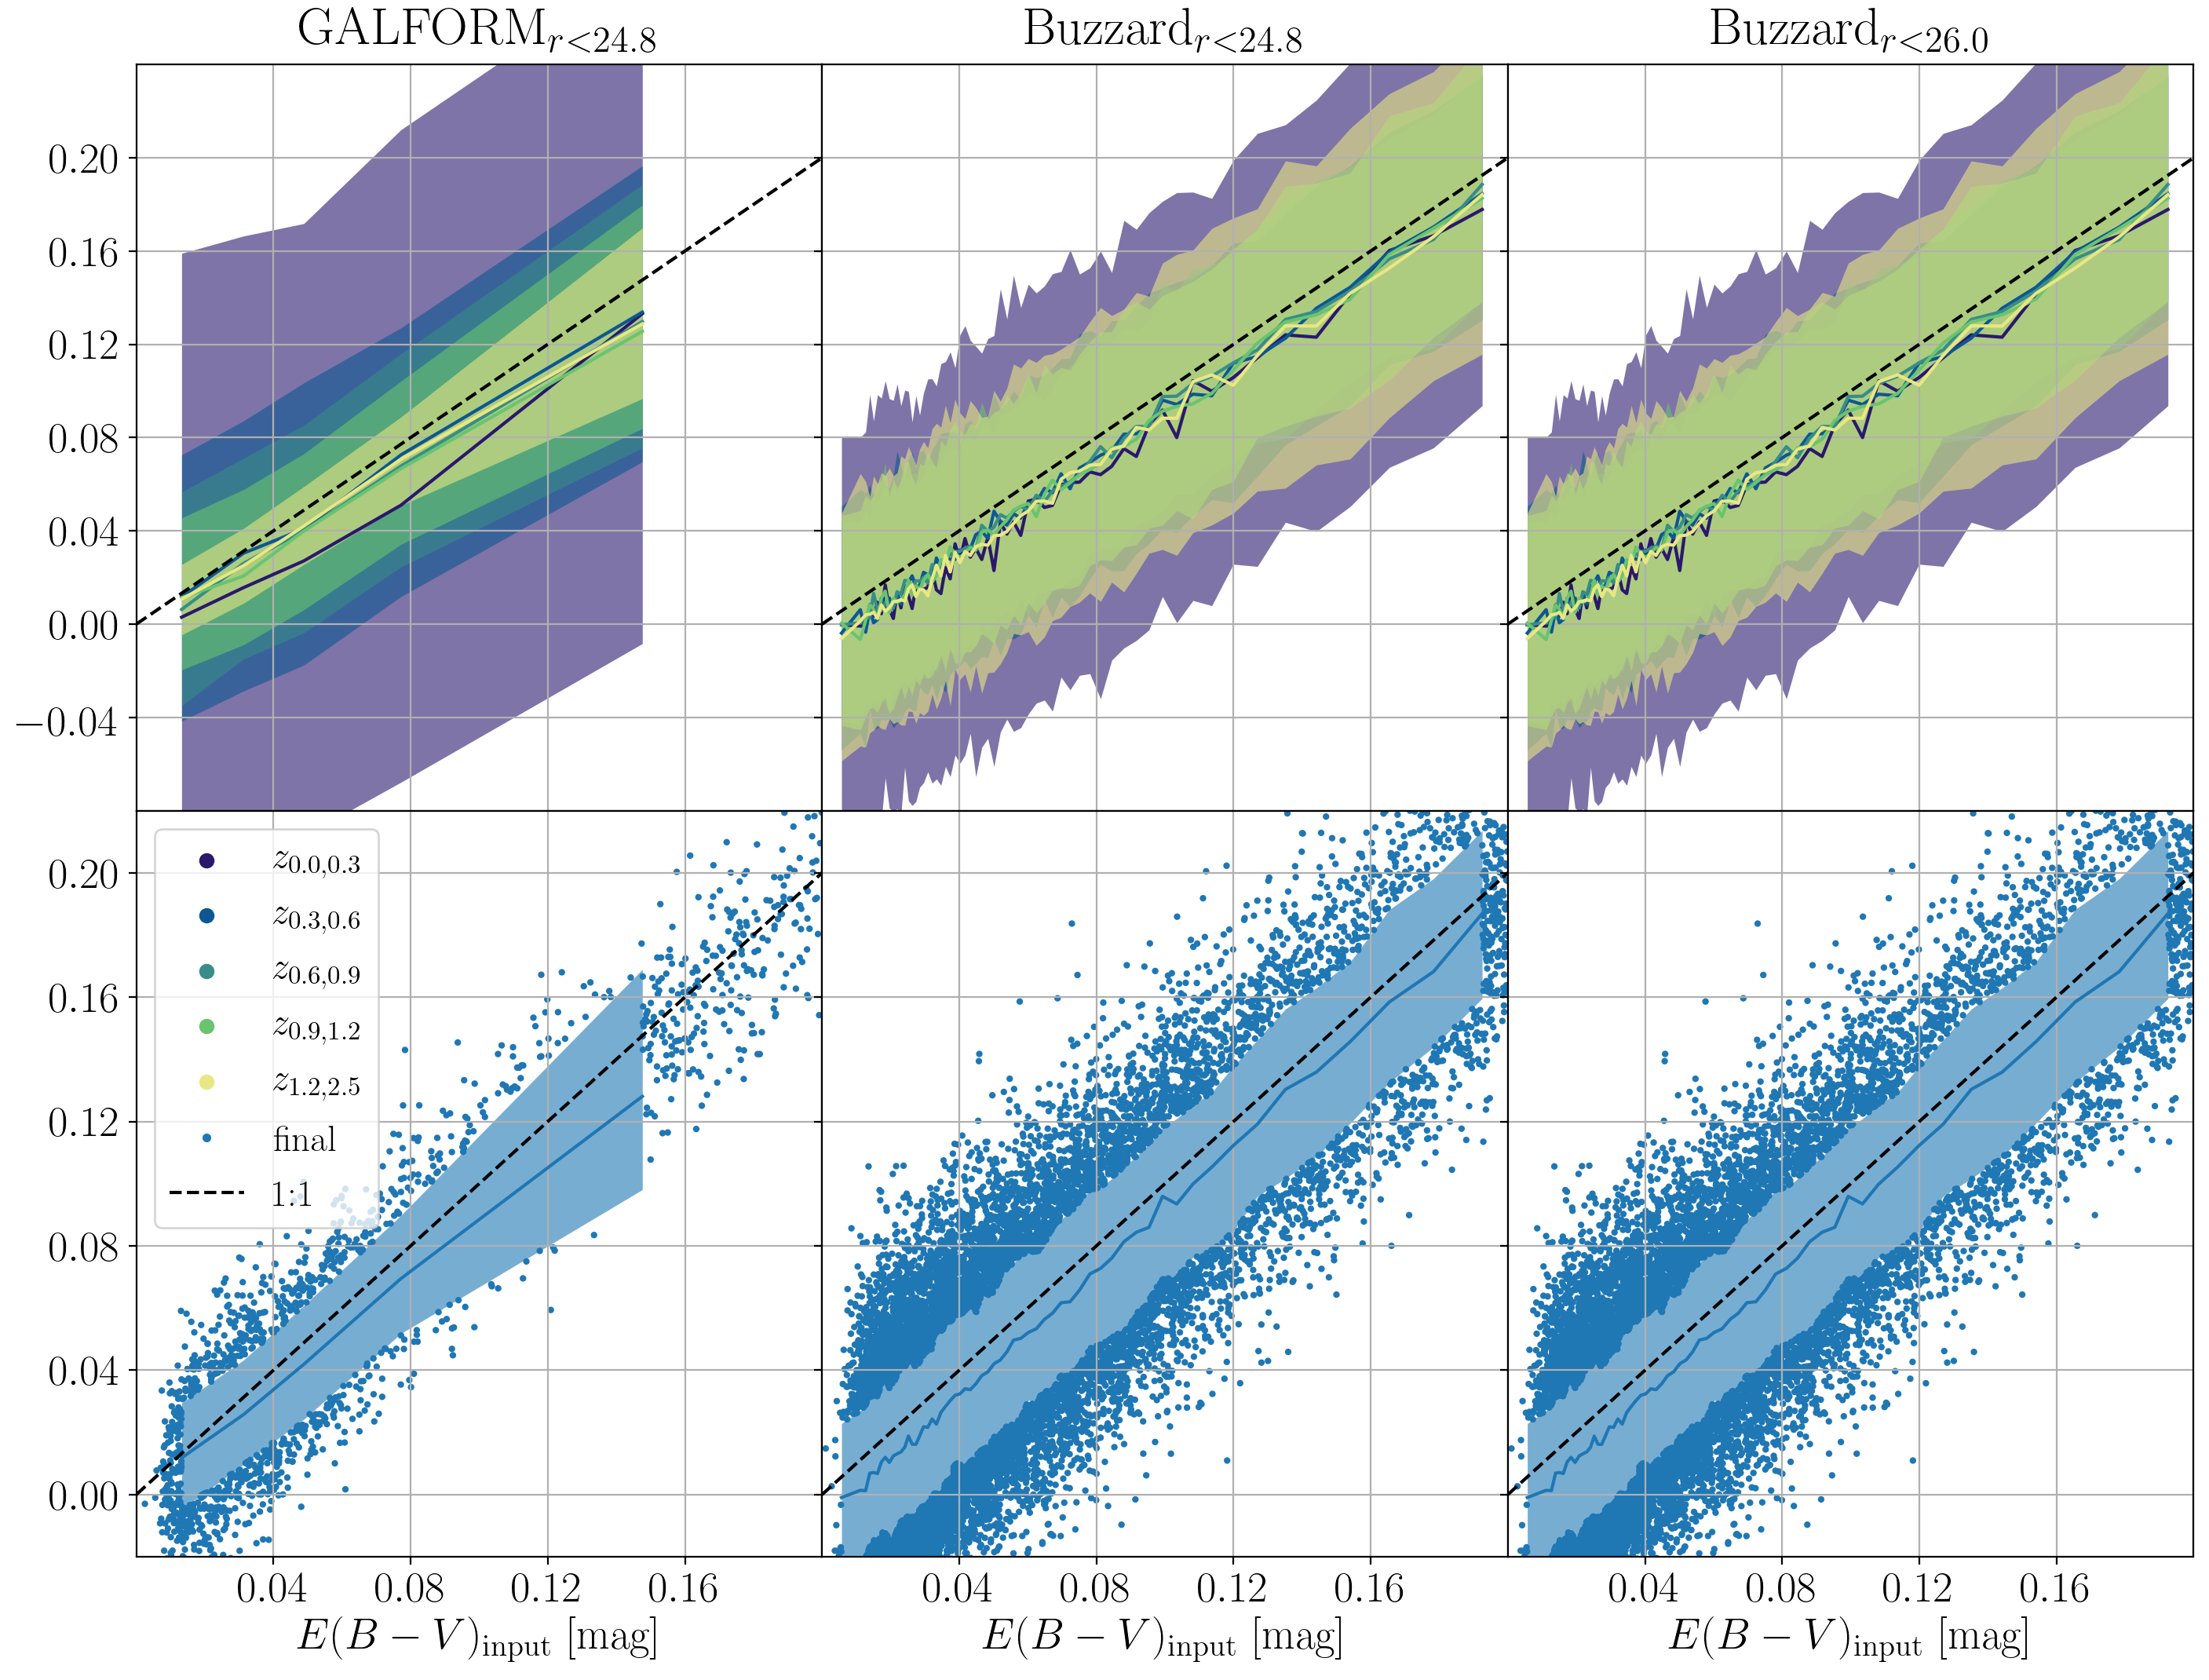

In [61]:
col_map=cm.get_cmap(cmo.cm.haline)

fig=plot.figure(figsize=new_fig_size*2)
spec=gs.GridSpec(nrows=2,ncols=3,figure=fig,wspace=0,hspace=0,left=0.07,right=0.98,bottom=0.07,top=0.95)
fax=[[fig.add_subplot(spec[0,0]),fig.add_subplot(spec[0,1]),fig.add_subplot(spec[0,2])],
     [fig.add_subplot(spec[1,0]),fig.add_subplot(spec[1,1]),fig.add_subplot(spec[1,2])]]
temp=fax[0][1].get_yaxis().set_ticklabels([])
temp=fax[0][2].get_yaxis().set_ticklabels([])
temp=fax[0][0].get_xaxis().set_ticklabels([])
temp=fax[0][1].get_xaxis().set_ticklabels([])
temp=fax[0][2].get_xaxis().set_ticklabels([])
temp=fax[1][1].get_yaxis().set_ticklabels([])
temp=fax[1][2].get_yaxis().set_ticklabels([])
for i in range(2):
    for j in range(3):
        temp=fax[0][j].get_yaxis().set_ticks([-0.04,0,0.04,0.08,0.12,0.16,0.2])
        temp=fax[1][j].get_yaxis().set_ticks([0,0.04,0.08,0.12,0.16,0.2])
        temp=fax[i][j].get_xaxis().set_ticks([0.04,0.08,0.12,0.16])
        fax[i][j].set_rasterized(True)

#GALFORM
fax[0][0].set_title('GALFORM$_{r<24.8}$')
for i in range(L):
    sp.errorband(map_GAL_r248_n9['input_map'],map_GAL_r248_n9['output_map_combined'][i],line_stat='median',bin_type='equal',
                 band_stat_low=16,band_stat_high=84,line=True,ax=fax[0][0],xlim=[0,0.2],ylim=[-0.08,0.24],bins=5,
                 band_kw={'color':col_map(1.0*i/(L-0.8)),'alpha':0.6},line_kw={'c':col_map(1.0*i/(L-0.8))})
sp.axline(a=1,c='k',linestyle='dashed',ax=fax[0][0])
sp.errorband(map_GAL_r248_n9['input_map'],map_GAL_r248_n9['output_map'],line_stat='median',bin_type='equal',bins=5,
                 band_stat_low=16,band_stat_high=84,line=True,ax=fax[1][0],xlim=[0,0.2],ylim=[-0.02,0.22],
                 band_kw={'color':'C0','alpha':0.6},line_kw={'c':'C0'})
outpoint_x,outpoint_y=[],[]
path=fax[1][0].get_children()[0].get_paths()[0]
for i in range(len(map_GAL_r248_n9['input_map'])):
    if not path.contains_point([map_GAL_r248_n9['input_map'][i],map_GAL_r248_n9['output_map'][i]]):
        outpoint_x.append(map_GAL_r248_n9['input_map'][i])
        outpoint_y.append(map_GAL_r248_n9['output_map'][i])
outpoint_x,outpoint_y=[np.array(outpoint_x),np.array(outpoint_y)]
sp.scatter(outpoint_x,outpoint_y,ax=fax[1][0],xlim=[0,0.2],ylim=[-0.02,0.22],xlabel='$E(B-V)_\mathrm{input}$ [mag]',marker='.')
sp.axline(a=1,c='k',linestyle='dashed',ax=fax[1][0])


#Buzzard
fax[0][1].set_title('Buzzard$_{r<24.8}$')
for i in range(L):
    sp.errorband(map_Buz_r248_n9['input_map'],map_Buz_r248_n9['output_map_combined'][i],line_stat='median',bin_type='equal',
                 band_stat_low=16,band_stat_high=84,line=True,ax=fax[0][1],xlim=[0,0.2],ylim=[-0.08,0.24],
                 band_kw={'color':col_map(1.0*i/(L-0.8)),'alpha':0.6},line_kw={'c':col_map(1.0*i/(L-0.8))})
sp.axline(a=1,c='k',linestyle='dashed',ax=fax[0][1])
sp.errorband(map_Buz_r248_n9['input_map'],map_Buz_r248_n9['output_map'],line_stat='median',bin_type='equal',
                 band_stat_low=16,band_stat_high=84,line=True,ax=fax[1][1],xlim=[0,0.2],ylim=[-0.02,0.22],
                 band_kw={'color':'C0','alpha':0.6},line_kw={'c':'C0'})
outpoint_x,outpoint_y=[],[]
path=fax[1][1].get_children()[0].get_paths()[0]
for i in range(len(map_Buz_r248_n9['input_map'])):
    if not path.contains_point([map_Buz_r248_n9['input_map'][i],map_Buz_r248_n9['output_map'][i]]):
        outpoint_x.append(map_Buz_r248_n9['input_map'][i])
        outpoint_y.append(map_Buz_r248_n9['output_map'][i])
outpoint_x,outpoint_y=[np.array(outpoint_x),np.array(outpoint_y)]
sp.scatter(outpoint_x,outpoint_y,ax=fax[1][1],xlim=[0,0.2],ylim=[-0.02,0.22],xlabel='$E(B-V)_\mathrm{input}$ [mag]',marker='.')
sp.axline(a=1,c='k',linestyle='dashed',ax=fax[1][1])

#Buzzard deep
fax[0][2].set_title('Buzzard$_{r<26.0}$')
for i in range(L):
    sp.errorband(map_Buz_r248_n9['input_map'],map_Buz_r248_n9['output_map_combined'][i],line_stat='median',bin_type='equal',
                 band_stat_low=16,band_stat_high=84,line=True,ax=fax[0][2],xlim=[0,0.2],ylim=[-0.08,0.24],
                 band_kw={'color':col_map(1.0*i/(L-0.8)),'alpha':0.6},line_kw={'c':col_map(1.0*i/(L-0.8))})
sp.axline(a=1,c='k',linestyle='dashed',ax=fax[0][2])
sp.errorband(map_Buz_r248_n9['input_map'],map_Buz_r248_n9['output_map'],line_stat='median',bin_type='equal',
                 band_stat_low=16,band_stat_high=84,line=True,ax=fax[1][2],xlim=[0,0.2],ylim=[-0.02,0.22],
                 band_kw={'color':'C0','alpha':0.6},line_kw={'c':'C0'})
outpoint_x,outpoint_y=[],[]
path=fax[1][2].get_children()[0].get_paths()[0]
for i in range(len(map_Buz_r248_n9['input_map'])):
    if not path.contains_point([map_Buz_r248_n9['input_map'][i],map_Buz_r248_n9['output_map'][i]]):
        outpoint_x.append(map_Buz_r248_n9['input_map'][i])
        outpoint_y.append(map_Buz_r248_n9['output_map'][i])
outpoint_x,outpoint_y=[np.array(outpoint_x),np.array(outpoint_y)]
sp.scatter(outpoint_x,outpoint_y,ax=fax[1][2],xlim=[0,0.2],ylim=[-0.02,0.22],xlabel='$E(B-V)_\mathrm{input}$ [mag]',marker='.')
sp.axline(a=1,c='k',linestyle='dashed',ax=fax[1][2])

#Legend
fax[1][0].legend([lines.Line2D([0.5],[0.5],linestyle='',marker='o',color=col_map(0.0/(L-0.8))),
                  lines.Line2D([0.5],[0.5],linestyle='',marker='o',color=col_map(1.0/(L-0.8))),
                  lines.Line2D([0.5],[0.5],linestyle='',marker='o',color=col_map(2.0/(L-0.8))),
                  lines.Line2D([0.5],[0.5],linestyle='',marker='o',color=col_map(3.0/(L-0.8))),
                  lines.Line2D([0.5],[0.5],linestyle='',marker='o',color=col_map(4.0/(L-0.8))),
                  lines.Line2D([0.5],[0.5],linestyle='',marker='.',color='C0'),
                  lines.Line2D([0,1],[0,1],color='k',linestyle='dashed')],
                 ['$z_{0.0,0.3}$','$z_{0.3,0.6}$','$z_{0.6,0.9}$','$z_{0.9,1.2}$','$z_{1.2,2.5}$','final','1:1'],
                 fontsize=17,loc=2)

plot.savefig('../MW_results/map_recovery_n9.pdf')
plot.show()